In [1]:
from utils import lab_utils
from utils import transforms2 as extended_transforms
from utils import joint_transforms as joint_transforms

import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn 
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import json, string
from torch.utils import data
import numpy as np
import os

%matplotlib inline

In [2]:
# Define the data loader.
n_classes = 20
ignore_label = 19
root = 'dataset'

def obtain_dir(mode, root):
    # "mode" can be "train", "test", or "val".
    mask_path = os.path.join(root, 'gtFine', mode)
    img_path = os.path.join(root, 'leftImg8bit', mode)
    # The only difference between mask and image names are postfix.
    mask_postfix = '_gtFine_labelIds.png'
    # Get paths for all of 8-bit images and corresponding masks.
    items = []
    categories = os.listdir(img_path)
    for c in categories:
        c_items = [name.split('_leftImg8bit.png')[0] for name in os.listdir(os.path.join(img_path, c))]
        for it in c_items:
            item = (os.path.join(img_path, c, it + '_leftImg8bit.png'), os.path.join(mask_path, c, it + mask_postfix))
            items.append(item)
    # Return a set of tuples.
    return items


class CityScapes(data.Dataset):
    def __init__(self, mode, root, transform=None, target_transform=None,joint_transform=None):
        self.imgs = obtain_dir(mode, root)
        self.joint_transform = joint_transform
        self.transform = transform
        self.target_transform = target_transform
        # Only care about 19 classes. See the dataset paper for details.
        self.id_to_trainid = {-1: ignore_label, 0: ignore_label, 1: ignore_label, 2: ignore_label,
                              3: ignore_label, 4: ignore_label, 5: ignore_label, 6: ignore_label,
                              7: 0, 8: 1, 9: ignore_label, 10: ignore_label, 11: 2, 12: 3, 13: 4,
                              14: ignore_label, 15: ignore_label, 16: ignore_label, 17: 5,
                              18: ignore_label, 19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11, 25: 12, 26: 13, 27: 14,
                              28: 15, 29: ignore_label, 30: ignore_label, 31: 16, 32: 17, 33: 18}

    def __getitem__(self, index):
        img_path, mask_path = self.imgs[index]
        img, mask = Image.open(img_path).convert('RGB'), Image.open(mask_path)

        mask = np.array(mask)
        mask_copy = mask.copy()
        for k, v in self.id_to_trainid.items():
            mask_copy[mask == k] = v
        mask = Image.fromarray(mask_copy.astype(np.uint8))
        
        if self.joint_transform is not None:
            img, mask = self.joint_transform(img, mask)
        
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            mask = self.target_transform(mask)

        mask = torch.from_numpy(np.array(mask))
        mask = torch.Tensor.float(mask.view(1,mask.size(0),mask.size(1)))
        return img, mask

    def __len__(self):
        return len(self.imgs)

In [3]:
# In order to show segmentations in different colors.
palette = [128, 64, 128, 244, 35, 232, 70, 70, 70, 102, 102, 156, 190, 153, 153, 153, 153, 153, 250, 170, 30,
           220, 220, 0, 107, 142, 35, 152, 251, 152, 70, 130, 180, 220, 20, 60, 255, 0, 0, 0, 0, 142, 0, 0, 70,
           0, 60, 100, 0, 80, 100, 0, 0, 230, 119, 11, 32]
zero_pad = 256 * 3 - len(palette)
for i in range(zero_pad):
    palette.append(0)

def colorize_mask(mask):
    new_mask = Image.fromarray(mask.astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)
    return new_mask

In [5]:
class conv2DBatchNormRelu(nn.Module):
    def __init__(self, in_channels, n_filters, k_size,  stride, padding, bias=True):
        super(conv2DBatchNormRelu, self).__init__()

        self.cbr_unit = nn.Sequential(nn.Conv2d(int(in_channels), int(n_filters), kernel_size=k_size,
                                                padding=padding, stride=stride, bias=bias),
                                 nn.BatchNorm2d(int(n_filters)),
                                 nn.ReLU(inplace=True),)

    def forward(self, inputs):
        outputs = self.cbr_unit(inputs)
        return outputs

class segnetDown2(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetDown2, self).__init__()
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.maxpool_with_argmax = nn.MaxPool2d(2, 2, return_indices=True)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        unpooled_shape = outputs.size()
        outputs, indices = self.maxpool_with_argmax(outputs)
        return outputs, indices, unpooled_shape


class segnetDown3(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetDown3, self).__init__()
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.conv3 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.maxpool_with_argmax = nn.MaxPool2d(2, 2, return_indices=True)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        unpooled_shape = outputs.size()
        outputs, indices = self.maxpool_with_argmax(outputs)
        return outputs, indices, unpooled_shape


class segnetUp2(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetUp2, self).__init__()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)

    def forward(self, inputs, indices, output_shape):
        outputs = self.unpool(input=inputs, indices=indices, output_size=output_shape)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        return outputs


class segnetUp3(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetUp3, self).__init__()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.conv3 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)

    def forward(self, inputs, indices, output_shape):
        outputs = self.unpool(input=inputs, indices=indices, output_size=output_shape)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        return outputs

class segnet2(nn.Module):

    def __init__(self, n_classes=19, in_channels=3, is_unpooling=True):
        super(segnet2, self).__init__()

        self.in_channels = in_channels
        self.is_unpooling = is_unpooling

        self.down1 = segnetDown2(self.in_channels, 64)
        self.down2 = segnetDown2(64, 128)
        self.down3 = segnetDown3(128, 256)
        self.down4 = segnetDown3(256, 512)
        self.down5 = segnetDown3(512, 512)

        self.up5 = segnetUp3(512, 512)
        self.up4 = segnetUp3(512, 256)
        self.up3 = segnetUp3(256, 128)
        self.up2 = segnetUp2(128, 64)
        self.up1 = segnetUp2(64, n_classes)

    def forward(self, inputs):

        down1, indices_1, unpool_shape1 = self.down1(inputs)
        down2, indices_2, unpool_shape2 = self.down2(down1)
        down3, indices_3, unpool_shape3 = self.down3(down2)
        down4, indices_4, unpool_shape4 = self.down4(down3)
        down5, indices_5, unpool_shape5 = self.down5(down4)

        up5 = self.up5(down5, indices_5, unpool_shape5)
        up4 = self.up4(up5, indices_4, unpool_shape4)
        up3 = self.up3(up4, indices_3, unpool_shape3)
        up2 = self.up2(up3, indices_2, unpool_shape2)
        up1 = self.up1(up2, indices_1, unpool_shape1)

        return up1

In [6]:
import gc
from tqdm import tqdm_notebook as tqdm

class CrossEntropyLoss2d(nn.Module):
    #, ignore_index=255
    def __init__(self, weight=None, size_average=True):
        super(CrossEntropyLoss2d, self).__init__()
        #, ignore_index
        self.nll_loss = nn.NLLLoss2d(weight, size_average)
    def forward(self, inputs, targets):
        return self.nll_loss(F.log_softmax(inputs), targets.long())

class cross_entropy2d(nn.Module):
    def __init__(self, size_average=True):
        super(cross_entropy2d, self).__init__()
        self.size_average = size_average
        
    def forward(self, log_p, target, weight=None):
        n, c, h, w = inputs.size()
        log_p = F.log_softmax(log_p)
        log_p = log_p.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
        log_p = log_p[target.view(n, h, w, 1).repeat(1, 1, 1, c) >= 0]
        log_p = log_p.view(-1, c)

        target = target.long()
        mask = target >= 0
        target = target[mask]
        print(log_p.dim())
        loss = F.nll_loss(log_p, target, weight=weight, size_average=False)
        if self.size_average:
            loss /= mask.data.sum()
        return loss


class CrossEntropy2d(nn.Module):

    def __init__(self, size_average=True, ignore_label=255):
        super(CrossEntropy2d, self).__init__()
        self.size_average = size_average
        self.ignore_label = ignore_label

    def forward(self, predict, target, weight=None):
        """
            Args:
                predict:(n, c, h, w)
                target:(n, h, w)
                weight (Tensor, optional): a manual rescaling weight given to each class.
                                           If given, has to be a Tensor of size "nclasses"
        """
        target = target.long()
        n, c, h, w = predict.size()
        target_mask = (target >= 0) * (target != self.ignore_label)
        target = target[target_mask]
        predict = predict.transpose(1, 2).transpose(2, 3).contiguous()
        predict = predict[target_mask.view(n, h, w, 1).repeat(1, 1, 1, c)].view(-1, c)
        loss = F.cross_entropy(predict, target, weight=weight, size_average=self.size_average)
        return loss    

# Define the training function.
def train_model(network, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = False):
    
    # These are used to record loss and accuracy data for further plots.
    loss_train = np.zeros(n_epochs)
    loss_validate = np.zeros(n_epochs)
    
    if use_gpu:
        #network = torch.nn.DataParallel(network, device_ids=[0, 1])
        network = network.cuda()
        criterion = criterion.cuda()
        
    # Training loop.
    for epoch in range(0, n_epochs):
        
        cum_loss = 0.0
        gc.collect()

        # Make a pass over the training data.
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        network.train()  # This is important to call before training!
        for (i, (inputs, labels)) in enumerate(t):
            
            gc.collect()

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = labels.view(labels.size(0),labels.size(2), labels.size(3)) # To satisfy "CrossEntropyLoss2d"
            labels = Variable(labels)
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # Backward pass:
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step()

            # logging information.
            cum_loss += loss.data[0]
            t.set_postfix(loss = cum_loss/(i+1))
        
        # Record data for plotting figures.
        loss_train[epoch] = cum_loss/(i+1)
        
        # Make a pass over the validation data.
        cum_loss = 0.0
        t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
        network.eval()  # This is important to call before evaluating!
        for (i, (inputs, labels)) in enumerate(t):

            gc.collect()
            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs,volatile=True)
            labels = labels.view(labels.size(0),labels.size(2), labels.size(3)) # To satisfy "CrossEntropyLoss2d"
            labels = Variable(labels,volatile=True)
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # logging information.
            cum_loss += loss.data[0]
            t.set_postfix(loss = cum_loss/(i+1))
            
        # Record data for plotting figures.
        loss_validate[epoch] = cum_loss/(i+1)
    
    # Plot loss and accuracy.
    ep = np.arange(1, n_epochs+1, 1)
    plt.plot(ep, loss_train, 'ro',ep, loss_validate, 'bs')
    plt.xlabel('epoch')
    plt.ylabel('average loss')
    plt.legend(['training','validation'])
    plt.show()

In [7]:
# Load the fine-annotated Cityscapes dataset.
mean_std = ([103.939, 116.779, 123.68], [1.0, 1.0, 1.0])

imgTransform = transforms.Compose([extended_transforms.FlipChannels(),
                                   transforms.Scale((256,128)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*mean_std),
                                   transforms.Lambda(lambda x: x.mul_(255))])

target_transform = transforms.Compose([transforms.Scale((256,128),Image.NEAREST)])

"""
args = {
    'train_batch_size': 12,
    'epoch_num': 500,
    'lr': 1e-10,
    'weight_decay': 5e-4,
    'input_size': (128, 256),
    'momentum': 0.99,
    'lr_patience': 100,  # large patience denotes fixed lr
    'snapshot': '',  # empty string denotes no snapshot
    'print_freq': 20,
    'val_batch_size': 16,
    'val_save_to_img_file': False,
    'val_img_sample_rate': 0.05  # randomly sample some validation results to display
}
"""

"""
short_size = int(min(args['input_size']) / 0.875)

train_joint_transform = joint_transforms.Compose([
        joint_transforms.Scale(short_size),
        joint_transforms.RandomCrop(args['input_size']),
        joint_transforms.RandomHorizontallyFlip()
])

val_joint_transform = joint_transforms.Compose([
        joint_transforms.Scale(short_size),
        joint_transforms.CenterCrop(args['input_size'])
])
"""

trainset = CityScapes(mode = 'train', root = 'dataset',transform = imgTransform,
                      target_transform = target_transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size = 5, shuffle = True, num_workers = 0)

valset = CityScapes(mode = 'val', root = 'dataset', transform = imgTransform,
                    target_transform = target_transform)
valLoader = torch.utils.data.DataLoader(valset, batch_size = 1, shuffle = False, num_workers = 0)


( 0 ,.,.) = 
  19  19  19  ...   19  19  19
  19  19   8  ...   19  19  19
  19  19   8  ...   19  19  19
     ...       ⋱       ...    
  19  19  19  ...   19  19  19
  19  19  19  ...   19  19  19
  19  19  19  ...   19  19  19
[torch.FloatTensor of size 1x128x256]



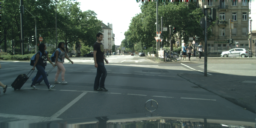

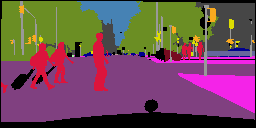

In [8]:
# This is for test only.
un_normalize = lab_utils.UnNormalize((0.4914, 0.4822, 0.4465), 
                                     (0.2023, 0.1994, 0.2010))

restore_transform = transforms.Compose([
        transforms.Lambda(lambda x: x.div_(255)),
        extended_transforms.DeNormalize(*mean_std),
        transforms.ToPILImage(),
        extended_transforms.FlipChannels()
])

img, mask = valset[1]
print(mask)
#mask = np.array(transforms.ToPILImage()(mask))
#mask = torch.from_numpy(mask)
#mask = torch.Tensor.float(mask.view(1,mask.size(0),mask.size(1)))
lab_utils.show_image(restore_transform(img));
lab_utils.show_image(colorize_mask(np.array(lab_utils.tensor2pil(mask/255))));

In [ ]:
# Train the neural network.
learningRate = 1e-4
set_momentum = 0.1
decay = 1e-6

gc.collect()

network = SegNet(n_classes, pretrained=True)
criterion = CrossEntropyLoss2d(size_average=False, ignore_index=ignore_label)

#criterion = CrossEntropy2d(size_average=False)

#optimizer = optim.SGD(network.parameters(), lr = learningRate, momentum = set_momentum, weight_decay = decay)
optimizer = optim.Adam(network2.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-6)
# Train the previously defined model.
train_model(network, criterion, optimizer, trainLoader, valLoader, n_epochs = 2, use_gpu = True)

HBox(children=(IntProgress(value=0, description='Training epoch 0', max=595), HTML(value='')))

594/|/100%|| 594/595 [13:40<00:01,  1.38s/it, loss=1.96]

HBox(children=(IntProgress(value=0, description='Validation epoch 0', max=500), HTML(value='')))

499/|/100%|| 499/500 [01:42<00:00,  4.87it/s, loss=2.41]

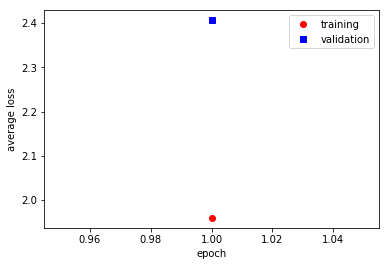

In [10]:
# Train another network
learningRate = 1e-4
set_momentum = 0.1
decay = 1e-5

gc.collect()

network2 = segnet2(n_classes=20)
#network2 = SegNet(n_classes, pretrained=True)
criterion = CrossEntropyLoss2d(size_average=True)
#optimizer = optim.SGD(network2.parameters(), lr = learningRate, momentum = set_momentum, weight_decay = decay)
#criterion = CrossEntropy2d(size_average=False, ignore_label=ignore_label)
#criterion = cross_entropy2d(size_average=True)
optimizer = optim.Adam(network2.parameters(), lr=2e-4, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-4)

# Train the previously defined model.
train_model(network2, criterion, optimizer, trainLoader, valLoader, n_epochs = 1, use_gpu = True)

In [46]:
learningRate = 1e-5
set_momentum = 0.6
decay = 1e-5

#optimizer = optim.Adam(network2.parameters(), lr=5e-4, betas=(0.9, 0.999), eps=1e-8, weight_decay=5e-4)
optimizer = optim.SGD(network2.parameters(), lr = learningRate, momentum = set_momentum, weight_decay = decay)
# For more training iterations.
train_model(network2, criterion, optimizer, trainLoader, valLoader, n_epochs = 5, use_gpu = True)

HBox(children=(IntProgress(value=0, description='Training epoch 0', max=595), HTML(value='')))

45/|/  8%|| 45/595 [00:59<12:09,  1.33s/it, loss=0.893]

KeyboardInterrupt: 


( 0 ,.,.) = 
  19  19  19  ...   19  19  19
  19  19   5  ...   19  19  19
  19  19   5  ...   19  19  19
     ...       ⋱       ...    
  19  19  19  ...   19  19  19
  19  19  19  ...   19  19  19
  19  19  19  ...   19  19  19
[torch.FloatTensor of size 1x128x256]



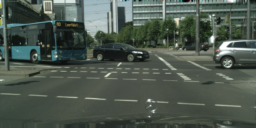

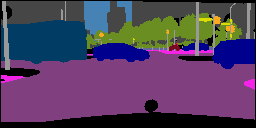


( 0 ,.,.) = 
  19  19  19  ...   19  19  19
  19  19   2  ...    2  19  19
  19   2   2  ...    2   2  19
     ...       ⋱       ...    
  19  19   0  ...    0   0  19
  19  19  19  ...    0   0  19
  19  19  19  ...   19  19  19
[torch.FloatTensor of size 1x128x256]



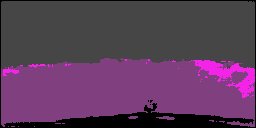

In [49]:
def pred_demo(network,image):
    network.eval()
    image = image.view(1,image.size(0),image.size(1), image.size(2))
    inputVar =  Variable(image,volatile=True).cuda()
    predictions = network(inputVar)
    #predictions = my_softmax(predictions)
    #predictions = F.softmax(predictions)
    #print(predictions)
    """
    predictions = predictions.data.squeeze().max(0)[1].cpu()
    predictions = predictions.view(1,predictions.size(0),predictions.size(1)).numpy()
    predictions = predictions/255
    predictions = torch.from_numpy(predictions).float()
    print(predictions)
    predictions = colorize_mask(np.array(lab_utils.tensor2pil(predictions)))
    lab_utils.show_image(predictions)
    """
    predictions = predictions.data.max(1)[1].squeeze().cpu()
    predictions = predictions.view(1,predictions.size(0),predictions.size(1))
    predictions = torch.Tensor.float(predictions)
    print(predictions)
    predictions = colorize_mask(np.array(lab_utils.tensor2pil(predictions/255)))
    lab_utils.show_image(predictions)

network2 = network2.cuda()

img, mask = valset[5]
print(mask)
lab_utils.show_image(restore_transform(img));
lab_utils.show_image(colorize_mask(np.array(lab_utils.tensor2pil(mask/255))));

pred_demo(network2,img)

In [31]:
torch.save(network2.state_dict(),'saved_network3')

In [9]:
network2 = segnet2()
network2.load_state_dict(torch.load('saved_network'))

In [136]:
gc.collect()

0